In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
from scipy.stats import binned_statistic, binned_statistic_dd


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


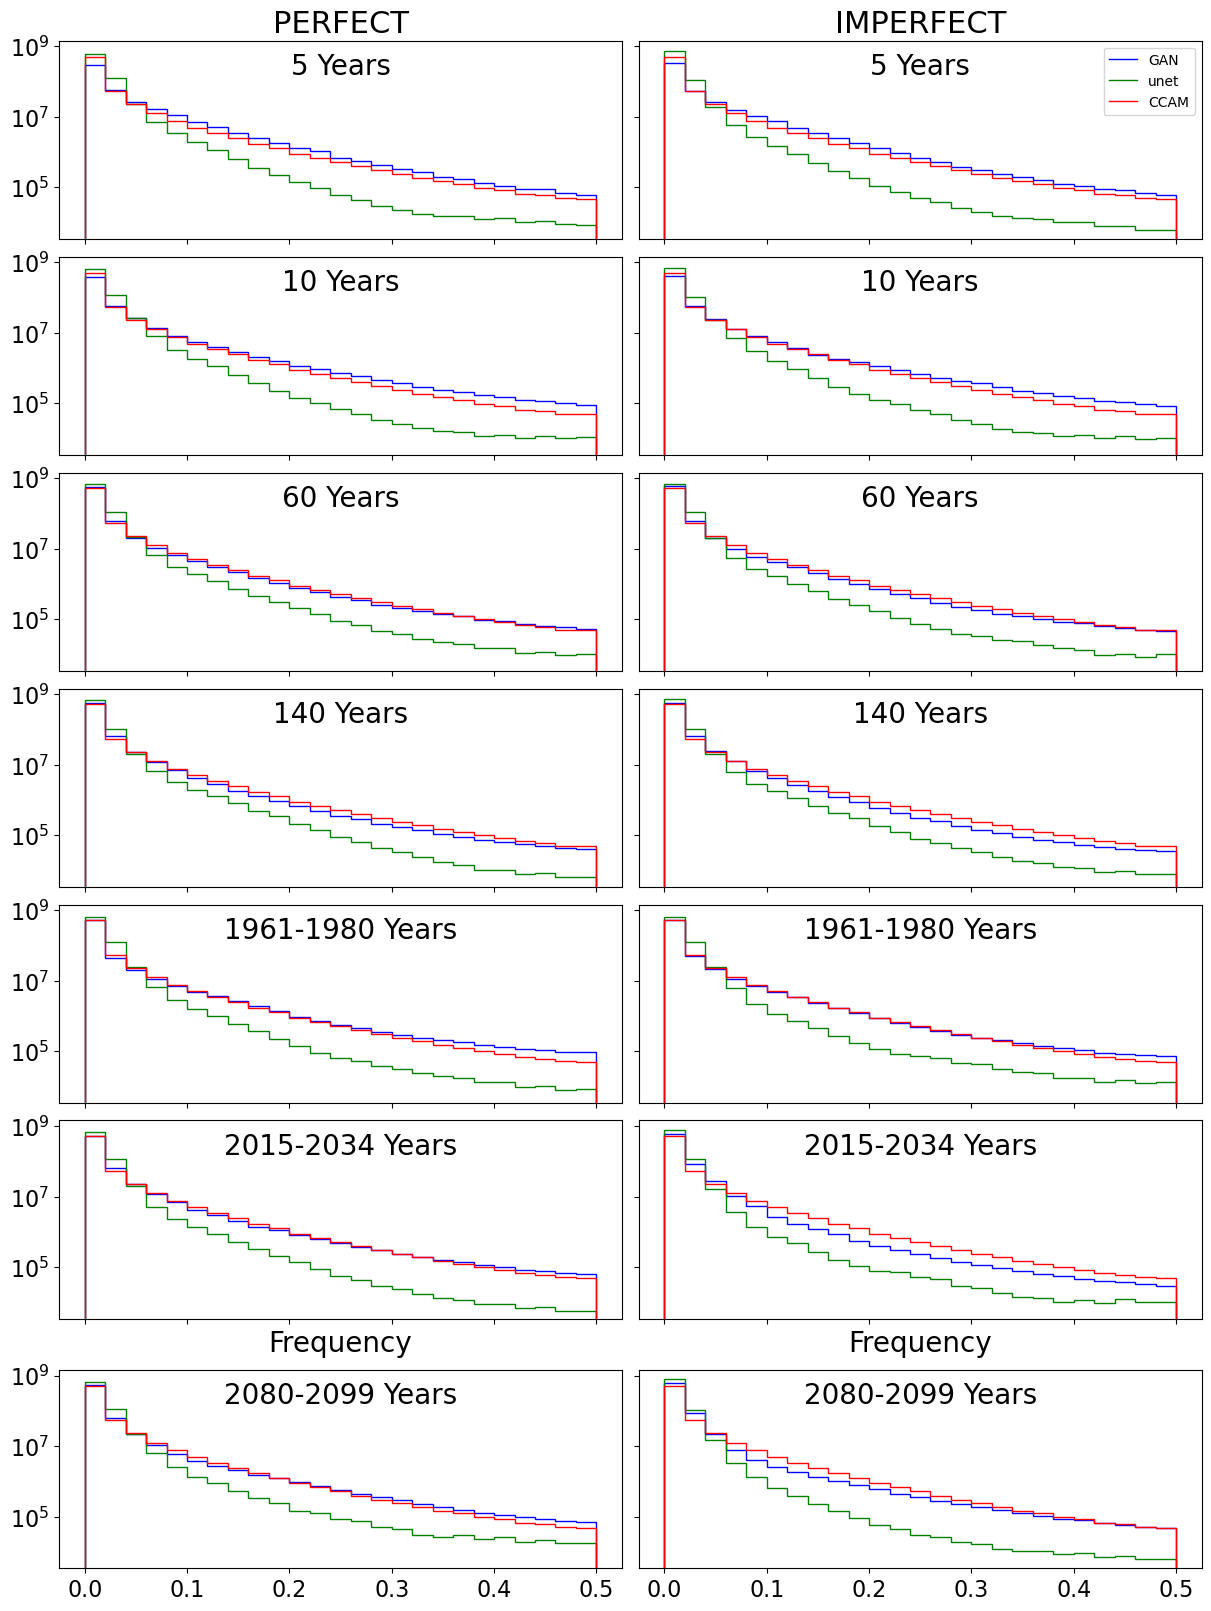

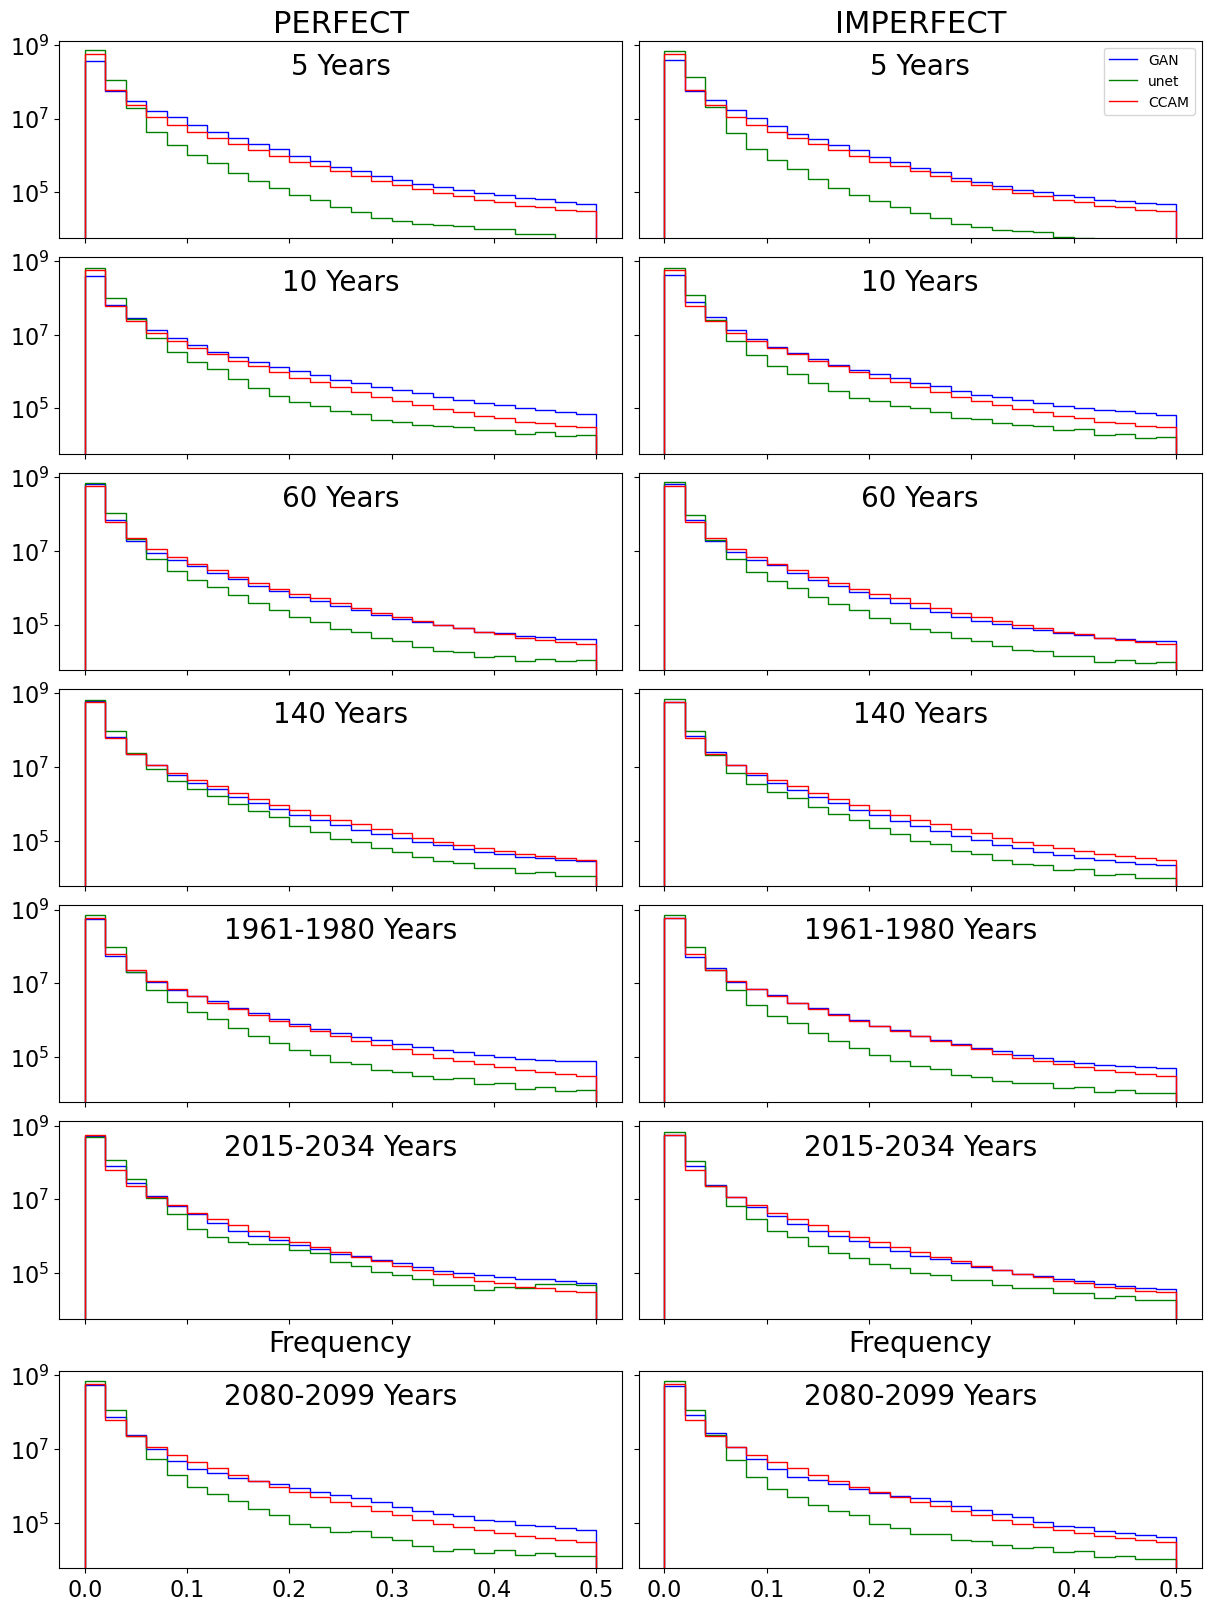

In [52]:
'''
Plot histograms 
'''


for gcm in ['EC-Earth3','NorESM2-MM']:

    for epoch in ['130']:

        #if os.path.exists(f'/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/histograms/{gcm}_epoch_{epoch}_{start}-{end}.png'):
        #    print('file exists, skipping')
        #    continue

        fig,axs = plt.subplots(7,2,figsize=(12,16),sharex=True,sharey=True,layout='constrained')

        for j,framework in enumerate(['perfect','imperfect']):

            gan_df = pd.read_csv(f'{result_dir}/{gcm}_GAN_{framework}_epoch_{epoch}_{start}-{end}_{metric}_PSD_counts.csv').drop('Unnamed: 0',axis=1)
            unet_df = pd.read_csv(f'{result_dir}/{gcm}_unet_{framework}_epoch_{epoch}_{start}-{end}_{metric}_PSD_counts.csv').drop('Unnamed: 0',axis=1)

            for i,n in enumerate(['5','10','60','140','1961-1980','2015-2034','2080-2099']):

                bins = gan_df['bin_left'].values.tolist() + [gan_df['bin_right'].values[-1]]

                gan_counts = gan_df[n]
                unet_counts = unet_df[n]
                ccam_counts = gan_df['CCAM']

                axs[i][j].stairs(gan_counts,bins,color='blue',label=f'GAN')
                axs[i][j].stairs(unet_counts,bins,color='green',label=f'unet')
                axs[i][j].stairs(ccam_counts,bins,color='red',label=f'CCAM')

                axs[i][j].set_yscale('log')

                axs[i][j].text(0.5,0.8,f'{n} Years', transform=axs[i][j].transAxes,ha='center', va='bottom', fontsize=20)

                axs[i][j].set_yscale('log')
                axs[i][j].tick_params(axis='y', labelsize=16)
                axs[i][j].tick_params(axis='x', labelsize=16)

                if i == 5:
                    axs[i][j].set_xlabel('Frequency',fontsize=20)

        axs[0][1].legend()
        axs[0][0].set_title('PERFECT',fontsize=22)
        axs[0][1].set_title('IMPERFECT',fontsize=22)



In [57]:
'''
RALSD
'''

def write_to_dict(result_dict,period,epoch,gcm,ml_type,framework,n,ralsd):
    
    result_dict['period'].append(period)
    result_dict['epoch'].append(epoch)
    result_dict['GCM'].append(gcm)
    result_dict['ml_type'].append(ml_type)
    result_dict['framework'].append(framework)
    result_dict['sample_n'].append(n)
    result_dict['ralsd'].append(ralsd)
    
    
def get_ralsd_df(start,end,metric):
    
    result_dict = {'GCM':[],'ml_type':[],'framework':[],'period':[],'sample_n':[],'ralsd':[],'epoch':[]}

    for epoch in [120,125,130]:
        for gcm in ['EC-Earth3','NorESM2-MM']:
            for ml_type in ['GAN','unet']:
                for framework in ['perfect','imperfect']:
            
                    df = pd.read_csv(f'{result_dir}/{gcm}_{ml_type}_{framework}_epoch_{epoch}_{start}-{end}_{metric}_PSD_counts.csv').drop('Unnamed: 0',axis=1)

                    ccam_counts = df['CCAM']

                    for i,n in enumerate(['5','10','20','60','100','140','1961-1980','2015-2034','2080-2099']):

                        ml_counts = df[n]
                        
                        log_diff = 10 * (np.log10(ml_counts) - np.log10(ccam_counts))
                        diff_rmse = np.sqrt(np.mean(log_diff ** 2))

                        write_to_dict(result_dict,f'{start}-{end}',epoch,gcm,ml_type,framework,n,diff_rmse)

    df = pd.DataFrame.from_dict(result_dict)
    
    return(df)


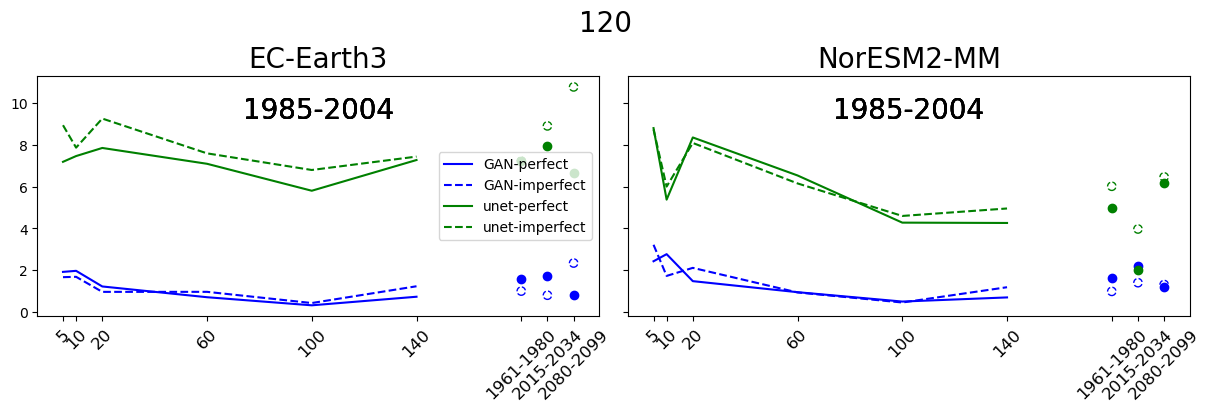

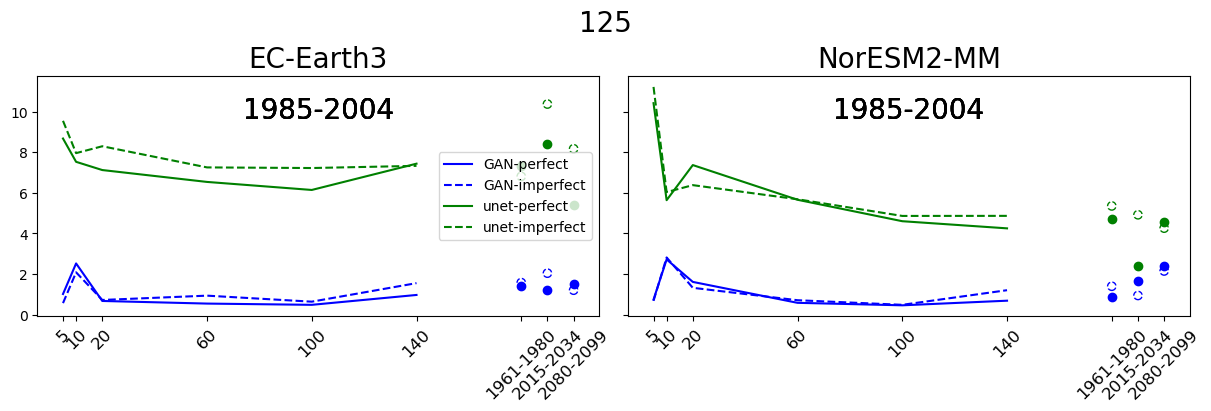

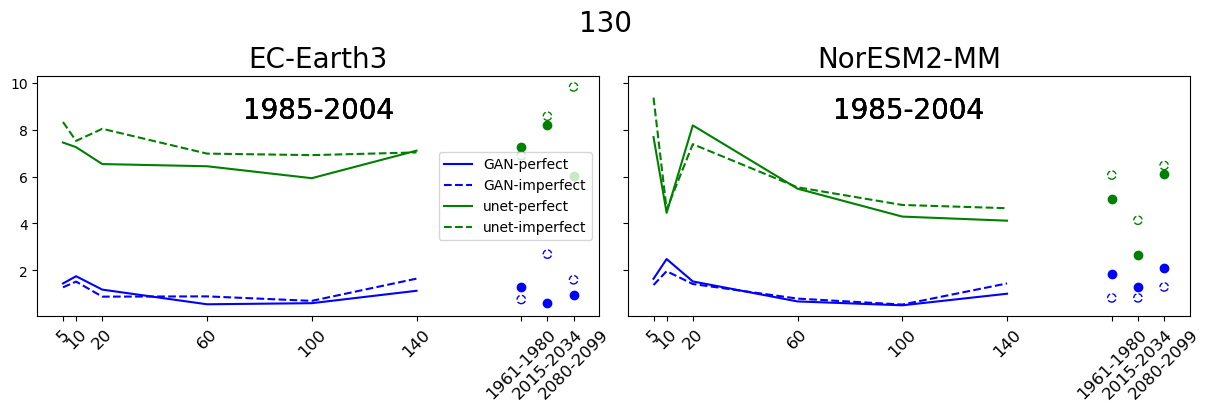

In [84]:
'''
Plot RALSD
'''

colors = {'GAN':'blue','unet':'green'}

start,end,metric = ('1985','2004','rx1d')

for epoch in [120,125,130]:
    
    fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True,sharex=True,layout='constrained')

    df = get_ralsd_df(start,end,metric)
    df_n = df[~df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
    df_20 = df[df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]

    for j,gcm in enumerate(['EC-Earth3','NorESM2-MM']):

        for ml_type in ['GAN','unet']:

            for framework in ['perfect','imperfect']:
                
                current_df = (df[(df['ml_type']==ml_type) & (df['framework']==framework) & (df['GCM']==gcm) & (df['epoch']==epoch)])
                
                # n-samplings
                df_n = current_df[~current_df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
                vals = df_n['ralsd']
                x_n = df_n['sample_n']
                
                axs[j].plot([int(v) for v in x_n],vals,color='blue' if ml_type == 'GAN' else 'green',linestyle = '-' if framework=='perfect' else '--',label=f'{ml_type}-{framework}')

                # 20-yr samplings
                df_20 = current_df[current_df['sample_n'].isin(['1961-1980','2015-2034','2080-2099'])]
                vals = df_20['ralsd']
                x_20 = df_20['sample_n']
                
                axs[j].scatter([180,190,200],vals,facecolors='none' if framework == 'imperfect' else colors[ml_type],edgecolors=colors[ml_type],linestyle = '-' if framework=='perfect' else '--')

                axs[j].set_xticks([int(v) for v in x_n] + [180,190,200],labels=x_n.values.tolist() + x_20.values.tolist(),fontsize=12,rotation=45)


                axs[j].set_title(gcm,fontsize=20)

                axs[j].text(0.5,0.8,f'{start}-{end}', transform=axs[j].transAxes,ha='center', va='bottom', fontsize=20)


    axs[0].legend()
    plt.suptitle(f'{epoch}',fontsize=20)

        